# Assignment 7: SVMs
## Author: Dustin Burnham
### Due: 8/25/2019

Age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope. Other measurements, which are easier to obtain, could be used to predict the age. According to the data provider, original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled (by dividing by 200) for use with machine learning algorithms such as SVMs.

The target field is “Rings”. Since the output is continuous the solution can be handled by a Support Vector Regression or it can be changed to a binary Support Vector Classification by assigning examples that are younger than 11 years old to class: ‘0’ and those that are older (class: ‘1’).

1. Convert the continuous output value from continuous to binary (0,1) and build an SVC
2. Using your best guess for hyperparameters and kernel, what is the percentage of correctly classified results?
3. Test different kernels and hyperparameters or consider using sklearn.model_selection.SearchGridCV. Which kernel performed best with what settings?
4. Show recall, precision and f-measure for the best model
5. Using the original data, with rings as a continuous variable, create an SVR model
6. Report on the predicted variance and the mean squared error

In [1]:
# Import Libraries
from sklearn import svm, metrics
from sklearn.svm import SVR
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import category_encoders as ce
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in and investigate data
abalone = pd.read_csv("Abalone.csv")

In [3]:
abalone.head()

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
abalone.describe()

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [5]:
abalone.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole Weight      float64
Shucked Weight    float64
Viscera Weight    float64
Shell Weight      float64
Rings               int64
dtype: object

#### One hot encode object features

In [6]:
# Get list of variables to be one hot encoded
cat_vars = list(abalone.dtypes.index[abalone.dtypes == 'object'])

In [7]:
# Create one hot encoder
handle = "indicator" # error return_nan value indicator
onehoter =  ce.OneHotEncoder(return_df = True,
                       cols = cat_vars,
                       drop_invariant = True,
                       use_cat_names = True, 
                       handle_missing = handle, 
                       handle_unknown = handle)

In [8]:
# One hot encode categorical data
onehoter.fit(abalone)
abalone = onehoter.transform(abalone)

In [9]:
# Create copy for later when we need target that is non-binary
original_abalone = abalone.copy()

### 1. Convert the continuous output value from continuous to binary (0,1) and build an SVC

In [10]:
# target > 11 set to 1, else 0
target = [0 if aba < 11 else 1 for aba in abalone['Rings']]
abalone['Rings'] = target

/Users/dusty/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/dusty/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


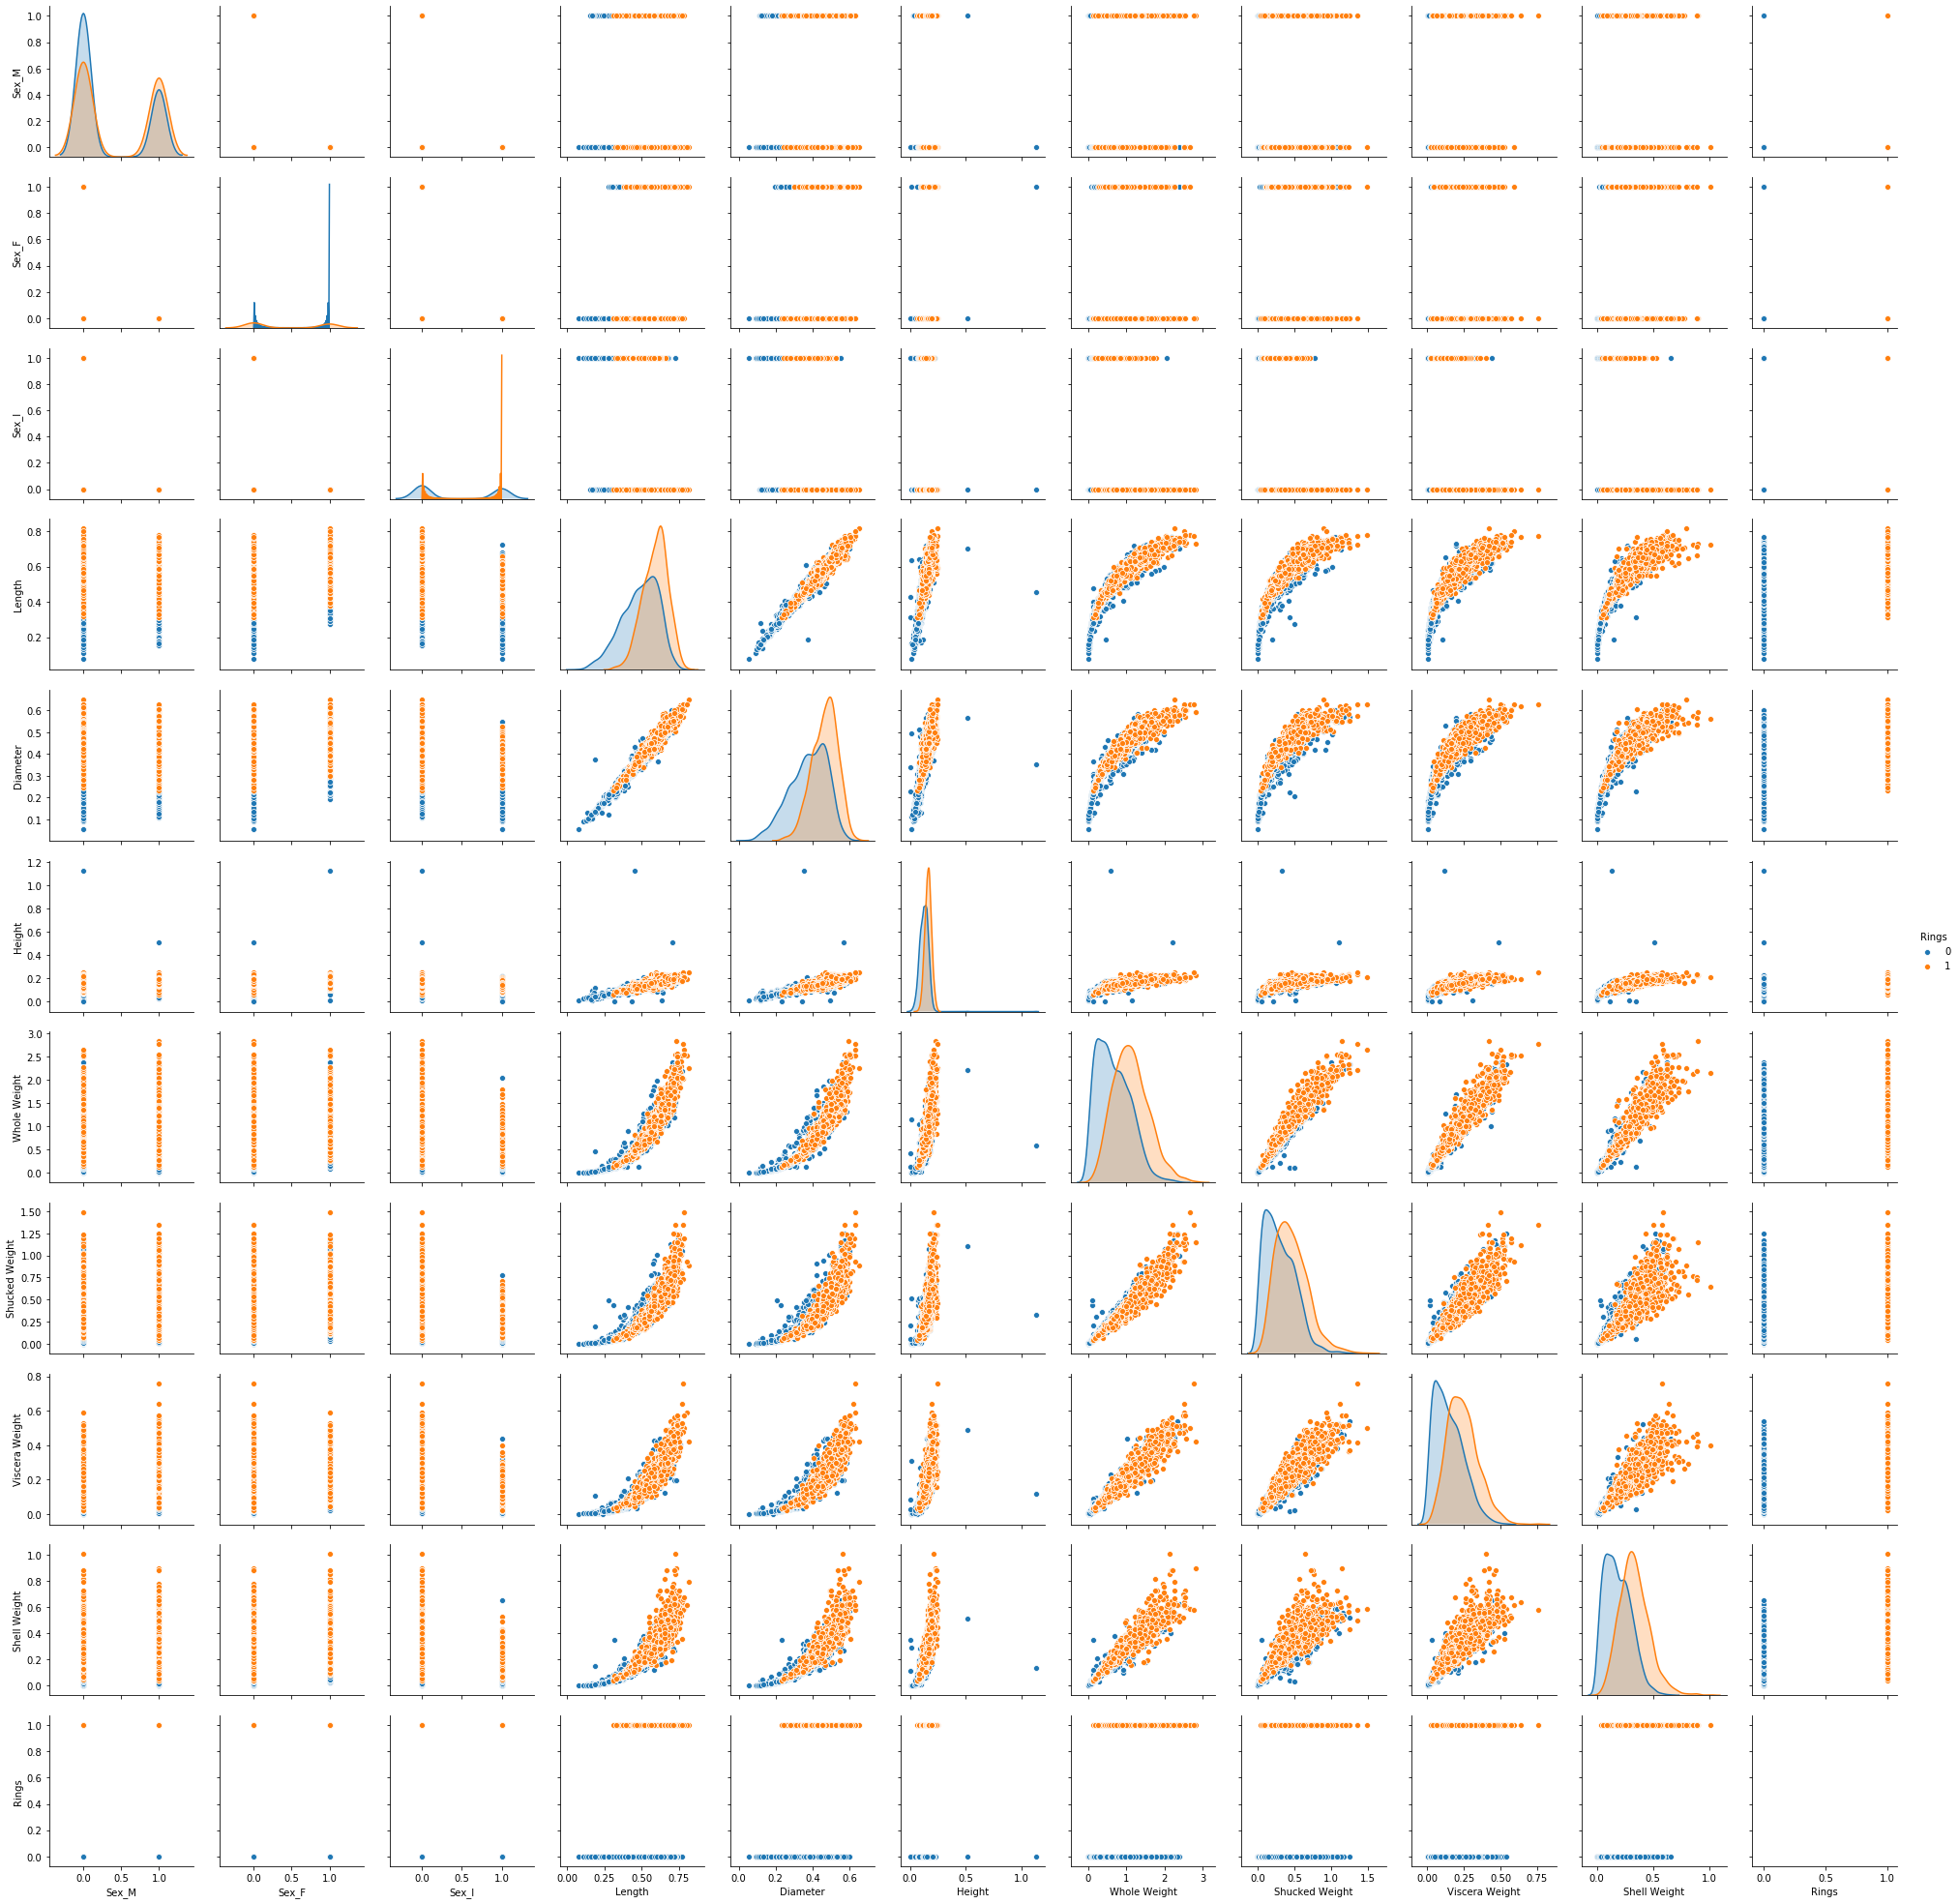

In [11]:
# Explore data where color is target
ax = sns.pairplot(abalone, hue='Rings')

Looking at the above data, there is a ton of overlap between abalone < 11 rings and greater than 11 rings for all data.  There are some differences, most notably there is clear separation between the targets when looking at the weight variables, so I expect them to be better at classification.

In [12]:
# Split into test and train data
X = abalone.iloc[:,0:10]
Y = abalone.iloc[:,10]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

### 2. Using your best guess for hyperparameters and kernel, what is the percentage of correctly classified results?

In [13]:
cost = 0.9 # best guess for penalty parameter of the error term
gamma = 'scale' # defines the influence of input vectors on the margins

In [14]:
# Create SVC model with best guess of hyperparameters
clf1 = svm.LinearSVC(C=cost, max_iter=5000)
clf1.fit(X_train, y_train)
clf1.predict(X_test)
print("LinearSVC")
print(classification_report(clf1.predict(X_test), y_test))

LinearSVC
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       919
           1       0.56      0.69      0.62       335

   micro avg       0.77      0.77      0.77      1254
   macro avg       0.72      0.75      0.73      1254
weighted avg       0.79      0.77      0.78      1254



### 3. Test different kernels and hyperparameters or consider using sklearn.model_selection.SearchGridCV. Which kernel performed best with what settings?

In [15]:
# Find optimal parameters for SVC model
hyper_parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[15, 20, 25], 'degree':[1,2,3], 'tol':[0.15, 0.2, 0.25]}
svc = svm.SVC(gamma="scale")
clf = GridSearchCV(svc, hyper_parameters, cv=5, iid = False, return_train_score=True)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'kernel': ('linear', 'rbf', 'poly'), 'C': [15, 20, 25], 'degree': [1, 2, 3], 'tol': [0.15, 0.2, 0.25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [16]:
# Get hyper parameters that maximize performance
scores = list(clf.cv_results_['mean_test_score'])
max_index = scores.index(max(scores))
params = clf.cv_results_['params'][max_index]

In [17]:
# Print best parameters
print(params)

{'C': 20, 'degree': 1, 'kernel': 'rbf', 'tol': 0.2}


In [18]:
# Print score of that model
scores[max_index]

0.7950761035007611

### 4. Show recall, precision and f-measure for the best model

In [19]:
print(classification_report(clf.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       883
           1       0.63      0.71      0.67       371

   micro avg       0.79      0.79      0.79      1254
   macro avg       0.75      0.77      0.76      1254
weighted avg       0.80      0.79      0.79      1254



Overall the accuracy for recall, precision and f-score are all around 0.8.  I think this shows that the model is solid all the way around at the binary classification, but that the features used for the model just wont be able to predict the target completely.  We can see this when looking at the plot above.  None of the features can clearly separate out the abalone with greater than 11 or not rings.

### 5. Using the original data, with rings as a continuous variable, create an SVR model

In [20]:
# Check original data to make sure 'Rings' isn't binary
original_abalone.head()

,Sex_M,Sex_F,Sex_I,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
0,1,0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,1,0,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0,1,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,1,0,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0,0,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


/Users/dusty/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/dusty/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dusty/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/dusty/anaconda3/envs/uwdatasci420/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


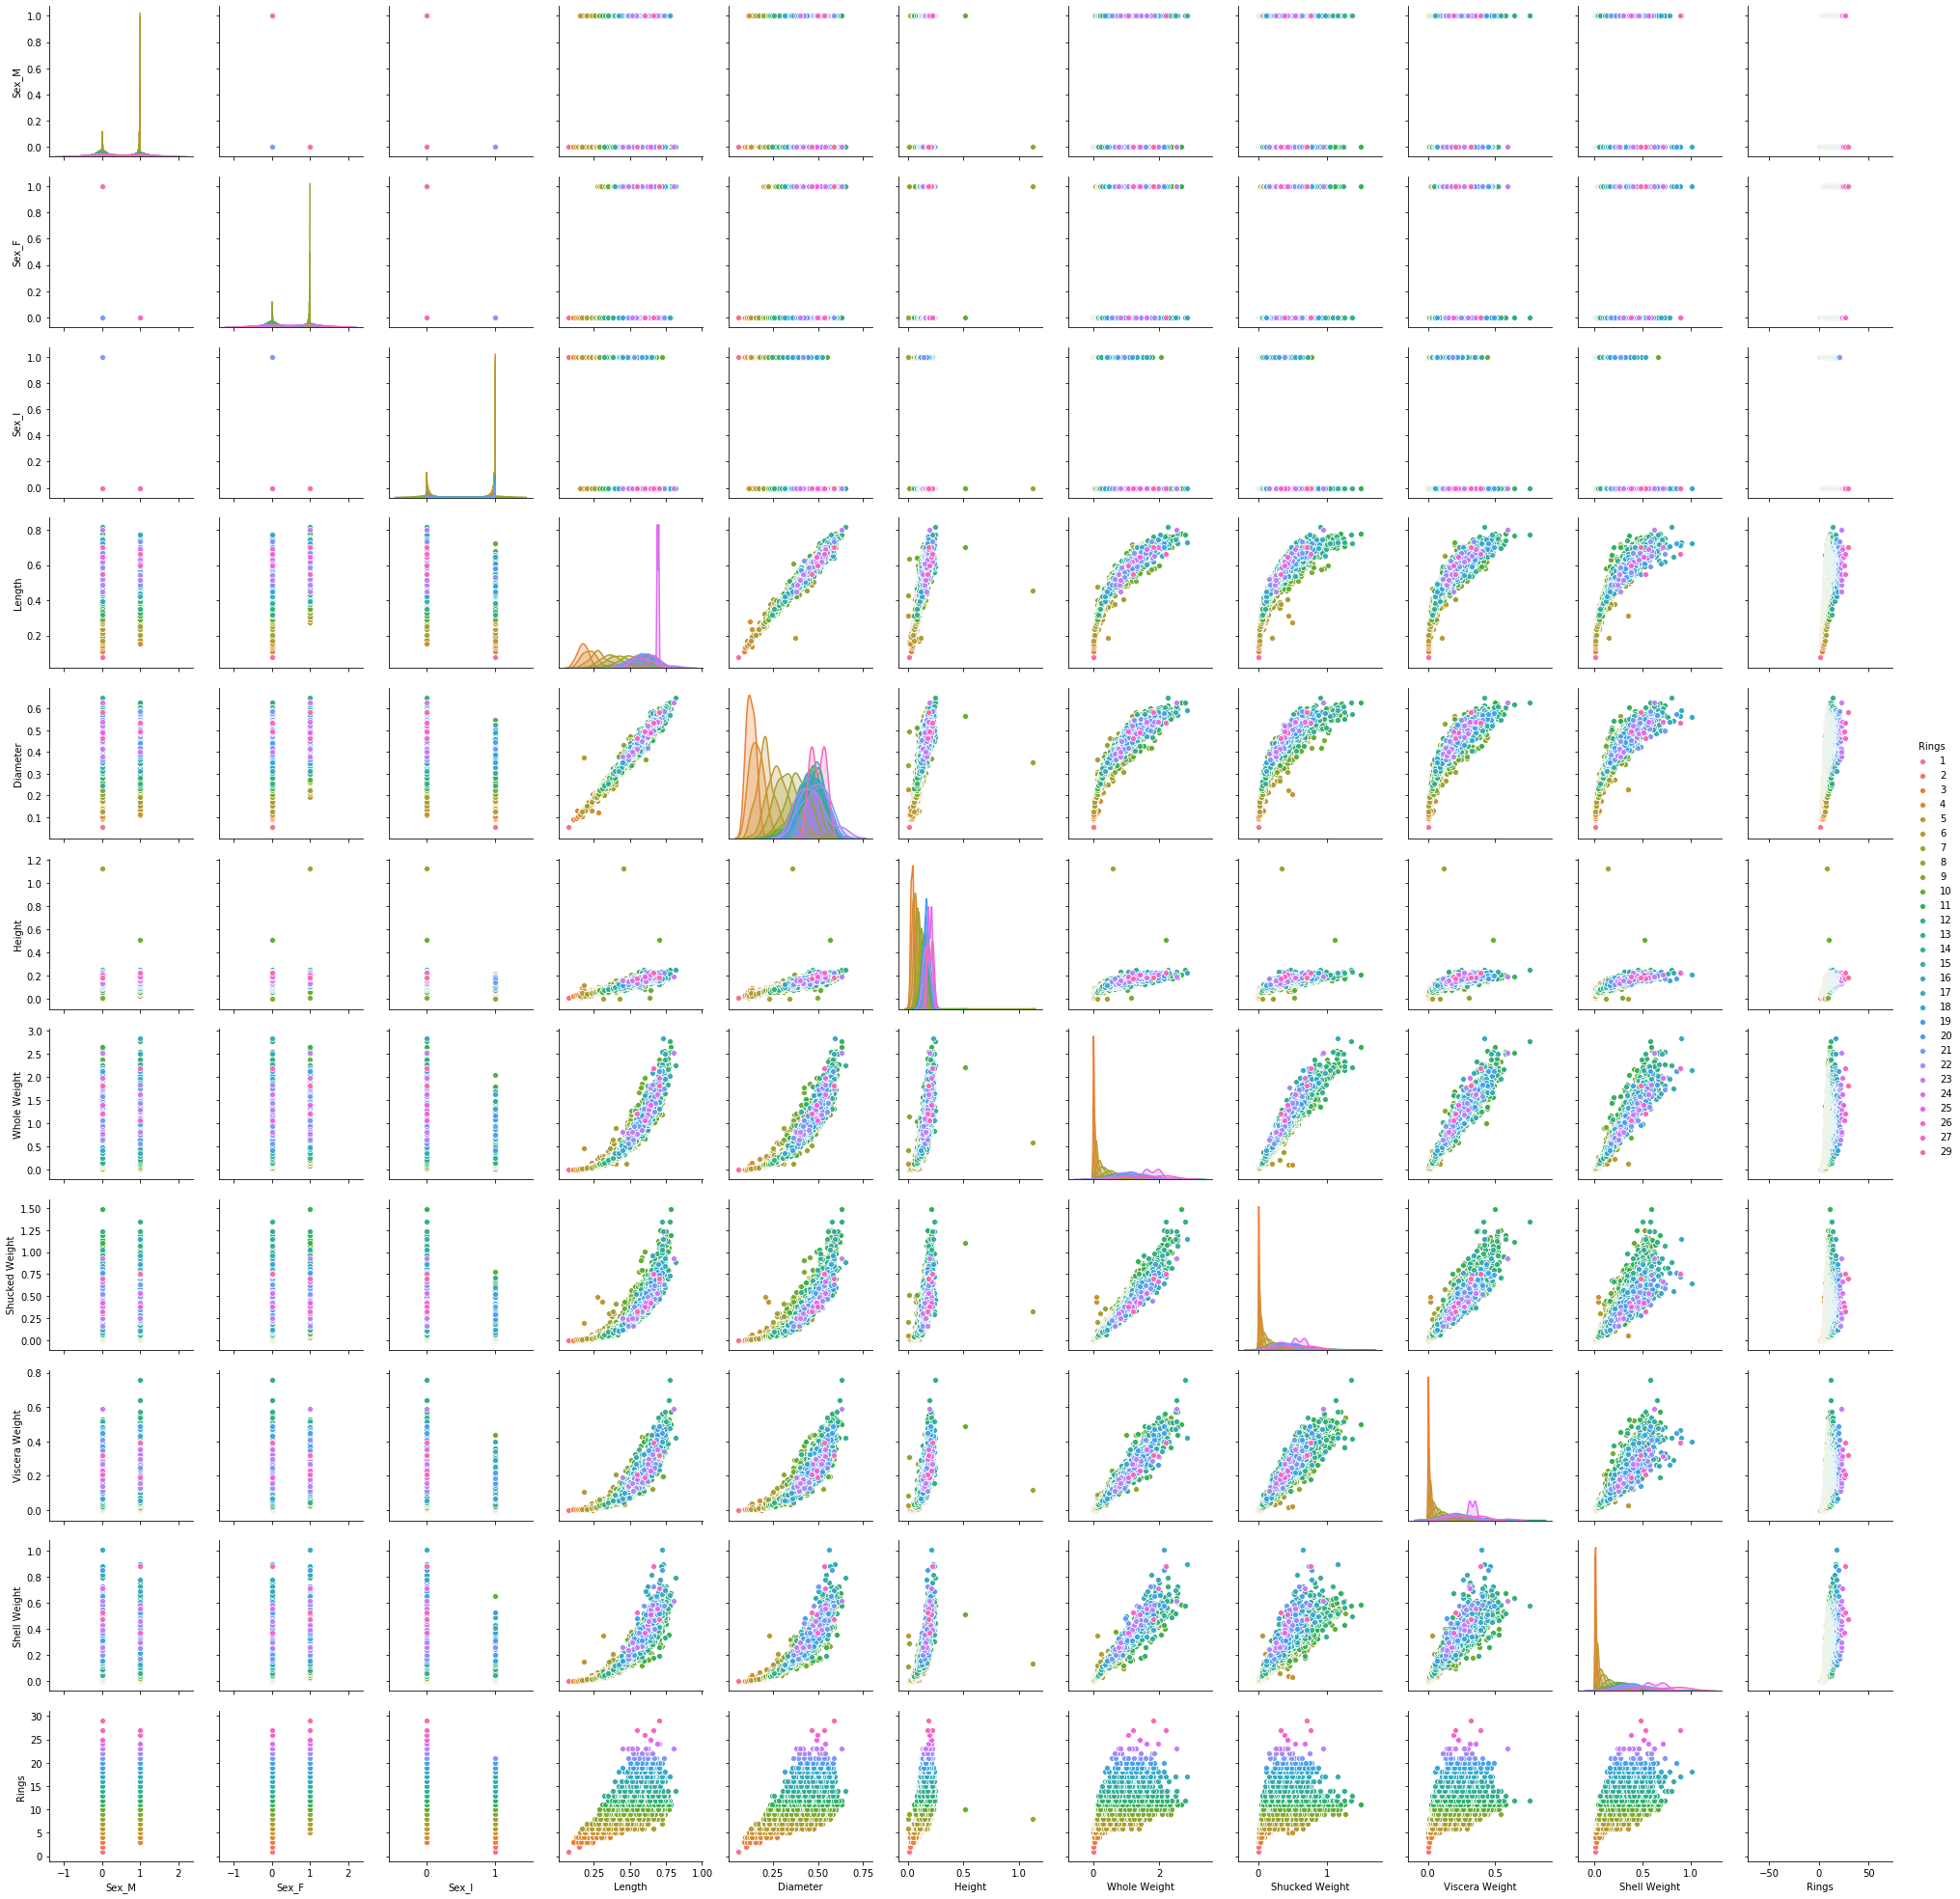

In [21]:
# Explore data where color is target
ax = sns.pairplot(original_abalone, hue='Rings')

In [22]:
# Use original data with non-binary target
X = original_abalone.iloc[:,0:10]
Y = original_abalone.iloc[:,10]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [23]:
# Find parameters that make the best support vector regression model
hyper_parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[50, 60, 70], 'degree':[1,2,3], 'tol':[0.1, 0.15, 0.2]}
svc = SVR(gamma="scale")
clf = GridSearchCV(svc, hyper_parameters, cv=5, iid = False, return_train_score=True)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'kernel': ('linear', 'rbf', 'poly'), 'C': [50, 60, 70], 'degree': [1, 2, 3], 'tol': [0.1, 0.15, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [24]:
# Get hyper parameters that maximize performance
scores = list(clf.cv_results_['mean_test_score'])
max_index = scores.index(max(scores))
params = clf.cv_results_['params'][max_index]

In [25]:
print(params)

{'C': 60, 'degree': 1, 'kernel': 'rbf', 'tol': 0.15}


In [26]:
scores[max_index]

0.5662905242501389

In [27]:
cont_pred = clf.predict(X_test)

### 6. Report on the predicted variance and the mean squared error

In [28]:
print("Predicted Variance:", np.var(cont_pred))

Predicted Variance: 5.615613504970342


In [29]:
print("Mean Square Error", metrics.mean_squared_error(cont_pred, y_test))

Mean Square Error 4.472678892715247


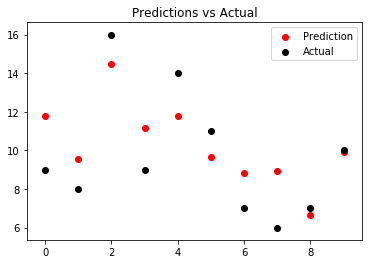

In [30]:
# Show samples of predictions vs actual
x_linspace = range(0, 10)
plt.scatter(x_linspace, cont_pred[:10], color='r', label='Prediction')
plt.scatter(x_linspace, y_test[:10], color='k', label='Actual')
plt.title("Predictions vs Actual")
plt.legend()
plt.show()

### Summary of SVR:
The SVR model does not do well predicting accurately compared to the best SVC model.  We can see by score of the best model that I could get, and by my graph of predictions vs actual value.  I believe this is because support vectors do a better job at predicting low cardinalty data vs high cardinality data.  When the target variable was greater than 11 or not, the score was 0.8.  After the change to predict the actual ring count, the model score went down to around 0.56.  As we can see by my plot, the predictions are close, but just not accurate enough to use.  We can also have thought about this after looking at the pairplot with the color being the different values of rings.  There is a lot of overlap between variables when looking at similar ring sizes.  For example, the distribution of weight variables for 17 rings very much overlaps with variables for 18 rings.  I think this is why the predictions are close, but the features just can't separate with high precision.  Ballpark is all that can be done when trying to classify the 28 different number of rings.